<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 语义分割（semantic segmentation）
> 语义分割重点关注于如何将图像分割成属于不同语义类别的区域。与⽬标检测不同，语义分割可以识别并理解图像中每⼀个像素的内容：其语义区域的标注和预测是像素级的。

##图像分割和实例分割
&emsp;&emsp;他们两之间的区别：
> *  图像分割将图像划分为若⼲组成区域，这类问题的⽅法通常利⽤图像中像素之间的相关性。它在训练
时不需要有关图像像素的标签信息，在预测时也⽆法保证分割出的区域具有我们希望得到的语义。只表示这个像素块是哪一类。
* 实例分割也叫同时检测并分割（simultaneous detection and segmentation），它研究如何识别图像中各个⽬标实例的像素级区域。与语义分割不同，实例分割不仅需要区分语义，还要区分不同的⽬标实例。表示这个像素块属于哪一类的哪一个实例物体。

![](http://jx.anderd.com/docker/SegVSS.png)

In [2]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.5 MB/s 


In [3]:
#语义分割数据集
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l


In [4]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
'4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [9]:
def read_voc_images(voc_dir,is_train=True):
  """读取所有voc图像并标注"""
  txt_fname = os.path.join(voc_dir,'ImageSets','Segmentation',
                           'train.txt'if is_train else 'val.txt')
  mode = torchvision.io.image.ImageReadMode.RGB
  with open(txt_fname,'r')as f:
    images = f.read().split()
  features,labels = [],[]
  for i,fname in enumerate(images):
    features.append(torchvision.io.read_image(os.path.join(voc_dir,'JPEGImages',f'{fname}.jpg')))
    labels.append(torchvision.io.read_image(os.path.join(voc_dir,'SegmentationClass',f'{fname}.png'),mode))
  return features,labels

In [10]:
train_features, train_labels = read_voc_images(voc_dir, True)#训练数据集

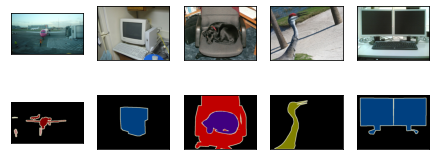

In [25]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [28]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],[0, 64, 128]]
              
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [26]:
def voc_colormap2label():
  """构建从RGB到VOC类别索引的映射"""
  colormap2label = torch.zeros(256 ** 3,dtype=torch.long)
  for i,colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
  return colormap2label

def voc_label_indices(colormap, colormap2label):
  """将VOC标签中的RGB值映射到它们的类别索引。"""
  colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
  idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256+ colormap[:, :, 2])
  return colormap2label[idx]

In [29]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]#在第⼀张样本图像中，⻜机头部区域的类别索引为1，而背景索引为0

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 'aeroplane')

In [30]:
def voc_rand_crop(feature, label, height, width):
  """随机裁剪特征和标签图像。"""
  rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
  feature = torchvision.transforms.functional.crop(feature, *rect)
  label = torchvision.transforms.functional.crop(label, *rect)
  return feature, label

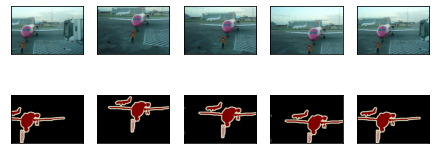

In [32]:
imgs = []
for _ in range(n):
  imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);